<p align="left">
<img src="figures/Unipd_1.png"  width="300"/> </p>
<p align="left">

<div align="center"> <h2 align="center"> Dipartimento di Fisica e Astronomia "Galileo Galilei" </h2> </div>
<div align="center"> <h2 align="center"> Master degree in Physics of Data</h2> </div>
<div align="center"> <h2 align="center"> Management of Physics Dataset, module B </h2> </div>
<div align="center"> <h2 align="center"> [surname] Theivan, Sarvenaz Babakhani, Reza Rajaee, Bahador Amjadi </h2> </div>
<br>
<br>

# Anomaly Detection and Predictive Maintenance for Industrial Devices

## Table of contents:
- [Introduction](#Introduction)
- [Setting Up the Environment](#require)
- [Loading The Data](#intro)
- [Assignments](#assign)
    - [Assignment 1: Anomaly Detection](#anomaly)
        - [Normalizing the Sampling Frequecies](#norm)
        - [Defining an Anomaly Metric](#metric)
        - [Building the Anomaly Matrix](#matrix)
        - [Measuring the Correlation](#threshold)
    - [Assignment 2: Anomaly Detection 2](#anomaly2)
        - [Normalizing the Sampling Frequecies](#norm2)
        - [Measuring the Correlation](#threshold2)
    - [Assignment 3: Predictive Maintenace](#predmain) 
        - [Input/Output Normalization](#ml_norm)
        - [Random Forest](#forest)
        - [Measuring Correlation using Random Forest Feature Importance](#corr)

- [Conclusion](#Conclusion)

# Introduction

Nowadays, IoT and Big Data allowed retrieving significant benefits from the devices’
data sensors. Typically in the academic world, this means, the possibility to perform
some analysis as time series forecasting, data predictions, and data classification.
Despite this being extremely useful from the research side, from the enterprise point
of view, the necessities are instead to exploit the huge amounts of data generated by
devices, to perform some predictions for Anomaly detection (AD) and Predictive Maintenance
(PM):

• Anomaly detection (also outlier detection) is the identification of rare items, events,
or observations that raise suspicions by differing significantly from the majority of
the data (Wikipedia Anomaly Detection). <br>

• Predictive maintenance techniques are designed to help determine the condition of
in-service equipment to estimate when maintenance should be performed. (Wikipedia
Predictive Maintenance)
In the light of the above, it’s clear, that both AD and PM are extremely important for a
company to identify possible problems on their devices, anomalies during a production
process, perform maintenance before a fault of a device, or reduce the cost of recurrent
maintenance (that is done even if it is not necessary).
The following project is based on real data

## Setting Up the Environment <a class="anchor" id="require"></a>

In [1]:
import findspark
findspark.init('/usr/local/spark')

In [2]:
from pyspark.sql.functions import col, max as max_, min as min_
import matplotlib.pyplot as plt
import pyspark.pandas as ps
from pyspark.sql.types import DoubleType, FloatType, LongType
from pyspark.sql.functions import *
import pyspark.sql.functions as func
from pyspark.sql.window import Window
import numpy as np

In [3]:
import pyspark

In [4]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [5]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
        .master("spark://10.67.22.217:7077")\
        .appName("First spark application")\
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
        .config("spark.executor.memory", "4g")\
        .config("spark.driver.memory", "1g")\
        .getOrCreate()

#SparkConf().set("spark.driver.maxResultSize", "2g"))

#.config("spark.default.parallelism", 9)\
#        .config("spark.executor.cores", 3)\



# .config("spark.sql.shuffle.partitions", 12)\

# .config("spark.sql.adaptive.enabled", "true")\
# .config("spark.sql.adaptive.coalescePartitions.enabled", "true")\


#.config("spark.driver.maxResultSize", "2g")\



spark

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/08 16:08:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
sc = spark.sparkContext
sc

<SparkContext master=spark://10.67.22.217:7077 appName=First spark application>

In [7]:
# sc.setSystemProperty("spark.dynamicAllocation.enabled", "true")

In [8]:
# sc.setSystemProperty("spark.serializer", "org.apache.spark.serializer.KryoSerializer")

In [9]:
# spark.conf.set('spark.sql.autoBroadcastHashJoin', -1)

## Loading the Data <a class="anchor" id="intro"></a>

All the data have a sampling frequency between the 30s to 1min that has to be normalized
to the same frequency before to performs an analysis. The data cover the period
from 1 Oct 2020 to 31 March 2021. If your cluster resources are not enough you can
split use the data for just three months ( 1 Jan - 31 Mar ).

<p align="left">
<img src="figures/data.jpg"  width="700"/> </p>
<p align="left">

In [10]:
# loading data
df = spark.read \
    .format('csv')\
    .option("header", "true")\
    .load('data.csv')
df = df.withColumn("when", (df.when.cast('bigint')/1000).cast('bigint'))

In [11]:
# persisting the dataset
df.cache().show()

+----------+------+------+-----+
|      when|  hwid|metric|value|
+----------+------+------+-----+
|1601510485|SW-065|   SA4|    0|
|1601510485|SW-065|   SA3|    0|
|1601510485|SW-065|   SA2|    0|
|1601510485|SW-065|   S34|    0|
|1601510485|SW-065|   S33|    1|
|1601510485|SW-065|   S25|    0|
|1601510485|SW-065|   S19|    0|
|1601510485|SW-065|   S17|    0|
|1601510485|SW-065|   S16|    0|
|1601510485|SW-065|   S15|    0|
|1601510485|SW-065|   S11|    0|
|1601510485|SW-065|   S10|   15|
|1601510485|SW-065|    S9|    0|
|1601510485|SW-065|    S8|    0|
|1601510485|SW-065|    S7|    0|
|1601510485|SW-065|    S6|    0|
|1601510485|SW-065|    S5|    1|
|1601510485|SW-065|    S3|  145|
|1601510485|SW-065|    S2|    2|
|1601510485|SW-065|    S1|    0|
+----------+------+------+-----+
only showing top 20 rows



In [12]:
df_limited = df.sort('when').limit(10000000)

In [13]:
df_limited.cache().count()

10000000

In [14]:
len(df_limited.select('metric', 'hwid').distinct().collect())

526

In [39]:
len(df.sort('when').select('metric', 'hwid').distinct().collect())

531

In [40]:
df.printSchema()

root
 |-- when: long (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: string (nullable = true)



# testing methods for normalizing frequencies on a trivial dataframe

In [13]:
# test on forward fill
values = [
    (1, "2015-12-01", None),
    (1, "2015-12-02", "U1"),
    (1, "2015-12-02", "U1"),
    (1, "2015-12-03", "U2"),
    (1, "2015-12-04", None),
    (1, "2015-12-05", None),
    (2, "2015-12-04", "U2"),
    (2, "2015-12-03", None),
    (2, "2015-12-02", "U3"),
    (2, "2015-12-05", None),
]
rdd = sc.parallelize(values)
df_test = rdd.toDF(["cookie_id", "c_date", "user_id"])
df_test = df_test.withColumn("c_date", df_test.c_date.cast("timestamp"))

In [14]:
window = (
    Window
    .orderBy('c_date')
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)
)

final = (
    df_test
    .withColumn('UserIDFilled', last('user_id', ignorenulls=True).over(window))
)

window = (
    Window
    .orderBy('c_date')
    .rowsBetween(Window.currentRow, Window.unboundedFollowing)
)

final_2 = (
    final
    .withColumn('UserIDFilled', first('UserIDFilled', ignorenulls=True).over(window))
)

In [99]:
# the forward fill works
final_2.show()

+---------+-------------------+-------+------------+
|cookie_id|             c_date|user_id|UserIDFilled|
+---------+-------------------+-------+------------+
|        1|2015-12-01 00:00:00|   null|          U1|
|        1|2015-12-02 00:00:00|     U1|          U1|
|        1|2015-12-02 00:00:00|     U1|          U1|
|        2|2015-12-02 00:00:00|     U3|          U3|
|        1|2015-12-03 00:00:00|     U2|          U2|
|        2|2015-12-03 00:00:00|   null|          U2|
|        2|2015-12-04 00:00:00|     U2|          U2|
|        1|2015-12-04 00:00:00|   null|          U2|
|        1|2015-12-05 00:00:00|   null|          U2|
|        2|2015-12-05 00:00:00|   null|          U2|
+---------+-------------------+-------+------------+



In [77]:
# test on taking the most recent value out of a groupby
w = Window.partitionBy('cookie_id')

final.withColumn('max_date', max_('c_date').over(w))\
    .where(col('c_date') == col('max_date'))\
    .drop('max_date')\
    .show()

22/07/03 10:36:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/03 10:36:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---------+-------------------+-------+------------+
|cookie_id|             c_date|user_id|UserIDFilled|
+---------+-------------------+-------+------------+
|        1|2015-12-05 00:00:00|   null|          U2|
|        2|2015-12-05 00:00:00|   null|          U2|
+---------+-------------------+-------+------------+



# Functions

In [14]:
def get_reference_timegrid(df, ref_metrics, timestep):
    
    mask = df.metric == ref_metrics[0]
    
    for i in range(1, len(ref_metrics)):
        mask = (mask) | (df.metric == ref_metrics[i])
                         
    df_reference = df.filter(mask)

    epoch = (col("when").cast("bigint") / timestep).cast("bigint") * timestep

    with_epoch = df_reference.withColumn("epoch", epoch)

    # min and max over all the dataset
    min_epoch, max_epoch = with_epoch.select(min_("epoch"), max_("epoch")).first()

    # reference time grid
    ref_timegrid = spark.range(
        min_epoch, max_epoch + 1, timestep
    ).toDF("epoch")
    
    # persist the reference timegrid
    
    ref_timegrid.cache().count()
    
    return ref_timegrid

In [15]:
def normalize_frequencies(df_filtered, hwid, timestep, window_ff, window_bf, w_2, ref_timegrid):

    df_filtered_hwid = df_filtered.where(col('hwid')==hwid).select('when', 'value')


    # creating grid of time steps
    # for instance if I want time steps of 2 and my when column is (1, 2, 3, 4, 5)
    # the epoch column would be (0, 1, 1, 2, 2)
    # meausures with the same epoch occurred during the same timestep.
    # So if I have two or more measures per timestep we will have more records associated to the same epoch
    # (like in the dumb example before)

    epoch = (col("when").cast("bigint") / timestep).cast("bigint") * timestep 

    # adding the grid as a column of the dataframe
    with_epoch = df_filtered_hwid.withColumn("epoch", epoch)

    # take the most recent value for each epoch
    df_max = with_epoch.groupBy('epoch').agg(max("when").alias('when'))

    # joining to the original timegrid
    df_one_measure_per_epoch = df_max.join(broadcast(with_epoch.drop('epoch')), 'when', 'left')
    
    # joining to the reference timegrid
    df_filtered_norm = (ref_timegrid
                .join(broadcast(df_one_measure_per_epoch), "epoch", "left")
                .orderBy("epoch")
                .withColumn("index", row_number().over(w_2)))
    
    
    # forward filling the nan and null
    df_1 = (
        df_filtered_norm
        .withColumn('value_resampled', last('value',ignorenulls=True).over(window_ff))
        .withColumn('value_resampled', col('value_resampled').cast('double'))
    )
    

    # backwards filling
    df_2 = (
        df_1
        .withColumn('value_resampled', first('value_resampled', ignorenulls=True).over(window_bf))
    )

    df_final = df_2.drop('when', 'value')

    return df_final

## Defining the Anomaly Metric <a class="anchor" id="metric"></a>

The high frequency of turn off/on of the mentioned four metrics can be intrepreted as something wrong going on the system or in other words, an anomaly. In order to measure the correlation between the high frequncies of engines turning on and off and the value of other metrics, we need to define a metric in way that it increases as the frequency turn off/on increases. we call this metric "anomaly" and it is defined in the following way:

<p align="left">
<img src="figures/anomaly_metric.png"  width="700"/> </p>
<p align="left">

The XOR can be used as to measure the similarity between two values. XOR=0 if they are similar and 1 if they are differnt. We calculate the XOR of consecutive values of each metric (which are eighter 0 and 1 for those four specific metrics) and find the summation of XORs by a rolling window. The summation of XORs can be interpreted as an indicator of anomaly over differnt short periods of time. The window width can be modified. 

In [16]:
value_glob= 0.0
#building a function which measures the similarity of two consecutive value of a coloumn
@udf('float')
def xor(value):
    global value_glob   
    
    if np.float(value) != value_glob:
        xor_value = 1.0
        
    else:
        xor_value = 0.0
        
    value_glob = np.float(value)
        
    return(xor_value)

In [17]:
def get_anomaly_dataframe_by_hwid(df, metrics_list, hwids_list, window_size, timestep, ref_timegrid):
    
    w = (Window.orderBy(col("index")).rangeBetween(0, window_size))
    
        
    # defining a window to forward fill the nan and null value linked to the previous join
    window_ff = (
        Window
        .orderBy('index')
        .rowsBetween(Window.unboundedPreceding, Window.currentRow)
    )

    # defining window for backwards filling
    window_bf = (
        Window
        .orderBy('index')
        .rowsBetween(Window.currentRow, Window.unboundedFollowing)
    )

    w_2 = Window.orderBy("epoch")
    
    count = 0
    for metric in metrics_list:
                
        df_per_metric = df.where(col('metric') == metric)        
        
        for hwid in hwids_list:
    
            # get the dataframe with schema (index, when, ts_resampled, value_resampled) for given metric, hwid, timestep
            temp_norm = normalize_frequencies(df_filtered=df_per_metric, hwid=hwid, timestep=timestep, window_bf=window_bf, window_ff=window_ff, w_2=w_2, ref_timegrid=ref_timegrid)\
                        .drop('epoch', 'when', 'value')
            
            # creating a xor column
            temp_xor = temp_norm.withColumn("xor",xor(col('value_resampled'))).drop('value_resampled')
            
            #measuring the anomaly based on rolling window on xor column
            col_name = 'anom_' + metric + '_' + hwid
            temp_xor = temp_xor.withColumn(col_name, func.sum("xor").over(w)).drop('xor')
            
            if count !=0:
                result = result.join(temp_xor, ['index'], 'left')

            else:
                result = temp_xor
            
            count = 1
            
            
    return(result)


In [18]:
# to change the filtering -> it's better to put the filtering of metrics outside of the loop over hwid
# and then cache it in memory so that for the for loop would be faster
def normalize_frequencies_by_hwid(df, metrics_list, hwids_list, timestep, ref_timegrid):
    
    # defining a window to forward fill the nan and null value linked to the previous join
    window_ff = (
        Window
        .orderBy('index')
        .rowsBetween(Window.unboundedPreceding, Window.currentRow)
    )

    # defining window for backwards filling
    window_bf = (
        Window
        .orderBy('index')
        .rowsBetween(Window.currentRow, Window.unboundedFollowing)
    )
    
    # defining window to create index column
    w_2 = Window.orderBy("epoch")
    
    counter = 0
    for metric in metrics_list:
        
        df_per_metric = df.where(col('metric') == metric)
        
        for hwid in hwids_list:

            # get the dataframe with schema (index, when, ts_resampled, value_resampled) for given metric, hwid, timestep
            temp_norm = normalize_frequencies(df_filtered=df_per_metric, hwid=hwid, timestep=timestep, window_bf=window_bf, window_ff=window_ff, w_2=w_2, ref_timegrid=ref_timegrid)\
                        .drop('epoch', 'when', 'value')
            
            col_name = metric + '_' + hwid
            
            temp_norm = temp_norm.withColumn(col_name, col('value_resampled').cast('double')).drop('value_resampled')

            if counter != 0:
                # appending the dataframe to the results
                result = result.join(temp_norm, 'index', 'left')

            else: 
                # creating the results dataframe
                result = temp_norm
                
            counter = 1
            
            
    return result

# Assignment 1: Anomaly Detection

Each one of the devices in the dataset has 4 different engine which has to compress a gas
to chill or heat the environment. Continually turning ON and OFF these engines, with
high frequency, is not recommended and could indicate problems that happened during
the installation phase, deterioration of some mechanical parts, or not suitable external
environment conditions. For this point there are two tasks:

• Perform some distributed analysis that allows the users to identify possible anomalies on the high number of turn on and off these engines (an anomaly happens even
if just one of the engines of a device is turning on/off with high frequency)

• Identify some possible correlations between the higher frequency of turning on/off
of the engines, and the other variables. There are some patterns?

The metrics/variable that containes the information for the turning on/off the engines
are:

• S117 (engine 1)
• S118 (engine 2)
• S169 (engine 3)
• S170 (engine 4)


In [60]:
metrics = ['S117', 'S118', 'S169', 'S170'] # four metrics related to machines being turned off and on
hwids_list = ['SW-065', 'SW-088', 'SW-106', 'SW-115'] # hwids list

timestep = 120 #sec

# get the reference timegrid to renomralize the frequencies
ref_timegrid = get_reference_timegrid(df=df_limited, ref_metrics=metrics, timestep=timestep)

In [61]:
window_size = 100

## Normalizing the Sampling Frequencies <a class="anchor" id="norm"></a>

The dataset includes numerous records which are submitted over a varying sampling frequency. In order to normalize the sampling frequecny of over the whole dataset, we need to set a global time interval. Then based on this time interval we will resample the dataset. And in order to do so, we need to define our new time grid which uses the global interval as the fixed interval throughout the whole time period. Once we have the fixed-interval time-grid we resample the data like the following:

<p align="left">
<img src="figures/normalization.png"  width="700"/> </p>
<p align="left">

In [62]:
df_norm1 = get_anomaly_dataframe_by_hwid(df=df_limited, metrics_list=metrics, hwids_list=hwids_list,window_size=window_size, timestep=timestep, ref_timegrid=ref_timegrid)

In [63]:
%%time
df_norm1.cache().count() # 15 min

22/07/08 09:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 09:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 09:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 09:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 09:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 09:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 0

22/07/08 09:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 09:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 09:19:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


CPU times: user 944 µs, sys: 182 ms, total: 183 ms
Wall time: 7.72 s


28

In [64]:
df_norm1.printSchema()

root
 |-- index: integer (nullable = false)
 |-- anom_S117_SW-065: double (nullable = true)
 |-- anom_S117_SW-088: double (nullable = true)
 |-- anom_S117_SW-106: double (nullable = true)
 |-- anom_S117_SW-115: double (nullable = true)
 |-- anom_S118_SW-065: double (nullable = true)
 |-- anom_S118_SW-088: double (nullable = true)
 |-- anom_S118_SW-106: double (nullable = true)
 |-- anom_S118_SW-115: double (nullable = true)
 |-- anom_S169_SW-065: double (nullable = true)
 |-- anom_S169_SW-088: double (nullable = true)
 |-- anom_S169_SW-106: double (nullable = true)
 |-- anom_S169_SW-115: double (nullable = true)
 |-- anom_S170_SW-065: double (nullable = true)
 |-- anom_S170_SW-088: double (nullable = true)
 |-- anom_S170_SW-106: double (nullable = true)
 |-- anom_S170_SW-115: double (nullable = true)



## metric S117

In [65]:
anomalies_pd = df_norm1.toPandas()

In [66]:
anomalies_pd.head(5)

,index,anom_S117_SW-065,anom_S117_SW-088,anom_S117_SW-106,anom_S117_SW-115,anom_S118_SW-065,anom_S118_SW-088,anom_S118_SW-106,anom_S118_SW-115,anom_S169_SW-065,anom_S169_SW-088,anom_S169_SW-106,anom_S169_SW-115,anom_S170_SW-065,anom_S170_SW-088,anom_S170_SW-106,anom_S170_SW-115
0,1,3.0,0.0,1.0,2.0,2.0,0.0,2.0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0
1,2,3.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0
2,3,3.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0
3,4,3.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0
4,5,3.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [39]:
anomalies_pd['index']

0            1
1            2
2            3
3            4
4            5
         ...  
72020    72021
72021    72022
72022    72023
72023    72024
72024    72025
Name: index, Length: 72025, dtype: int32

In [67]:
anomaly_col = list(anomalies_pd.columns)

In [68]:
anomaly_col

['index',
 'anom_S117_SW-065',
 'anom_S117_SW-088',
 'anom_S117_SW-106',
 'anom_S117_SW-115',
 'anom_S118_SW-065',
 'anom_S118_SW-088',
 'anom_S118_SW-106',
 'anom_S118_SW-115',
 'anom_S169_SW-065',
 'anom_S169_SW-088',
 'anom_S169_SW-106',
 'anom_S169_SW-115',
 'anom_S170_SW-065',
 'anom_S170_SW-088',
 'anom_S170_SW-106',
 'anom_S170_SW-115']

In [69]:
anomaly_col.remove('index')

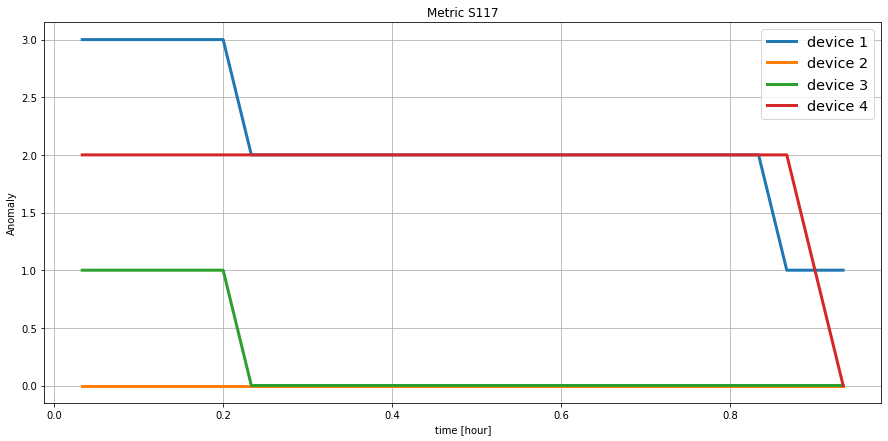

In [70]:
time_x = anomalies_pd['index']*2/60 # in hours
plt.figure(figsize=(15,7))
plt.plot(time_x, anomalies_pd[anomaly_col[0]], lw=3, label= "device 1")
plt.plot(time_x, anomalies_pd[anomaly_col[1]], lw=3, label= "device 2")
plt.plot(time_x, anomalies_pd[anomaly_col[2]], lw=3, label= "device 3")
plt.plot(time_x, anomalies_pd[anomaly_col[3]], lw=3, label= "device 4")
plt.legend(loc = "best", fontsize = 'x-large')
plt.xlabel('time [hour]')
plt.ylabel('Anomaly')
plt.title('Metric S117')
plt.grid()

## metric S118

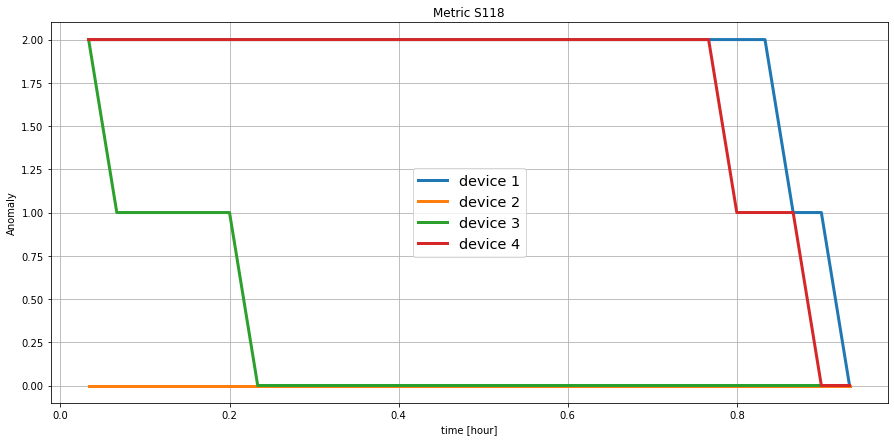

In [72]:
time_x = anomalies_pd['index']*2/60 # in hours
plt.figure(figsize=(15,7))
plt.plot(time_x, anomalies_pd[anomaly_col[4]], lw=3, label= "device 1")
plt.plot(time_x, anomalies_pd[anomaly_col[5]], lw=3, label= "device 2")
plt.plot(time_x, anomalies_pd[anomaly_col[6]], lw=3, label= "device 3")
plt.plot(time_x, anomalies_pd[anomaly_col[7]], lw=3, label= "device 4")
plt.legend(loc = "best", fontsize = 'x-large')
plt.xlabel('time [hour]')
plt.ylabel('Anomaly')
plt.title('Metric S118')
plt.grid()

## metric S169

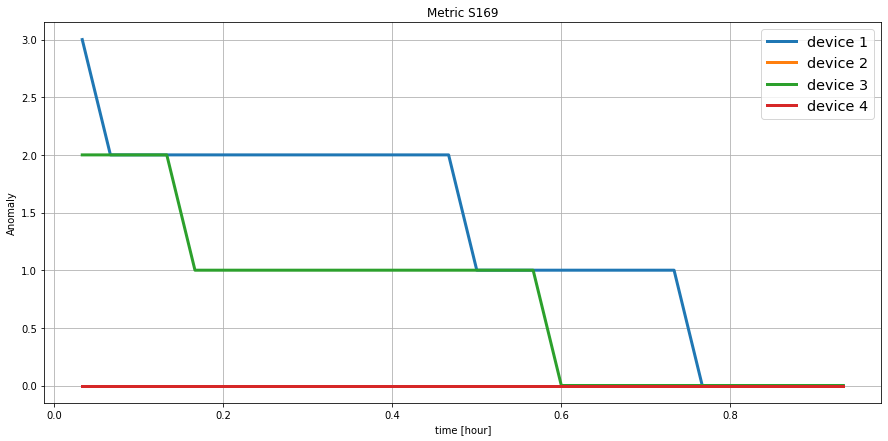

In [73]:
time_x = anomalies_pd['index']*2/60 # in hours
plt.figure(figsize=(15,7))
plt.plot(time_x, anomalies_pd[anomaly_col[8]], lw=3, label= "device 1")
plt.plot(time_x, anomalies_pd[anomaly_col[9]], lw=3, label= "device 2")
plt.plot(time_x, anomalies_pd[anomaly_col[10]], lw=3, label= "device 3")
plt.plot(time_x, anomalies_pd[anomaly_col[11]], lw=3, label= "device 4")
plt.legend(loc = "best", fontsize = 'x-large')
plt.xlabel('time [hour]')
plt.ylabel('Anomaly')
plt.title('Metric S169')
plt.grid()

## metric S170

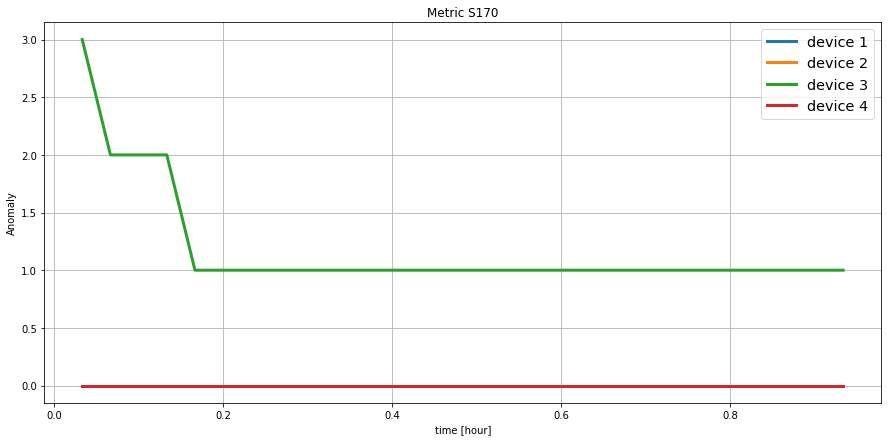

In [74]:
time_x = anomalies_pd['index']*2/60 # in hours
plt.figure(figsize=(15,7))
plt.plot(time_x, anomalies_pd[anomaly_col[12]], lw=3, label= "device 1")
plt.plot(time_x, anomalies_pd[anomaly_col[13]], lw=3, label= "device 2")
plt.plot(time_x, anomalies_pd[anomaly_col[14]], lw=3, label= "device 3")
plt.plot(time_x, anomalies_pd[anomaly_col[15]], lw=3, label= "device 4")
plt.legend(loc = "best", fontsize = 'x-large')
plt.xlabel('time [hour]')
plt.ylabel('Anomaly')
plt.title('Metric S170')
plt.grid()

In [ ]:
del anomalies_pd

# Normalizing frequencies of some other metrics

In [76]:
all_metrics = df.select('metric').distinct().collect()
all_metrics = [elem[0] for elem in all_metrics]

In [77]:
S_metrics = [x for x in all_metrics if x.startswith('S')]

In [78]:
metrics = ['S117', 'S118', 'S169', 'S170'] # four metrics related to machines being turned off and on

In [79]:
for elem in metrics:
    S_metrics.remove(elem)

In [80]:
sample_metrics = S_metrics[:8]
sample_metrics

['S39', 'SA5', 'SA10', 'S10', 'S201', 'S172', 'S178', 'S6']

In [158]:
timestep = 120 #sec
df_sample_metrics = normalize_frequencies_by_hwid(df_limited, metrics_list=sample_metrics, hwids_list=hwids_list, ref_timegrid=ref_timegrid, timestep=timestep)

In [159]:
df_sample_metrics.cache().count()

22/07/08 10:11:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 10:11:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 10:11:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 10:11:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 10:11:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 10:11:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 10:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 10:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 10:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 10:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 10:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 10:11:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

28

In [160]:
df_sample_metrics.printSchema()

root
 |-- index: integer (nullable = false)
 |-- S39_SW-065: double (nullable = true)
 |-- S39_SW-088: double (nullable = true)
 |-- S39_SW-106: double (nullable = true)
 |-- S39_SW-115: double (nullable = true)
 |-- SA5_SW-065: double (nullable = true)
 |-- SA5_SW-088: double (nullable = true)
 |-- SA5_SW-106: double (nullable = true)
 |-- SA5_SW-115: double (nullable = true)
 |-- SA10_SW-065: double (nullable = true)
 |-- SA10_SW-088: double (nullable = true)
 |-- SA10_SW-106: double (nullable = true)
 |-- SA10_SW-115: double (nullable = true)
 |-- S10_SW-065: double (nullable = true)
 |-- S10_SW-088: double (nullable = true)
 |-- S10_SW-106: double (nullable = true)
 |-- S10_SW-115: double (nullable = true)
 |-- S201_SW-065: double (nullable = true)
 |-- S201_SW-088: double (nullable = true)
 |-- S201_SW-106: double (nullable = true)
 |-- S201_SW-115: double (nullable = true)
 |-- S172_SW-065: double (nullable = true)
 |-- S172_SW-088: double (nullable = true)
 |-- S172_SW-106: doub

# [maybe plot some metrics]

## need to join the dataframe

In [161]:
df_ex1 = df_sample_metrics.join(df_norm1, ['index'], 'inner')

In [162]:
df_ex1.cache().count()

22/07/08 10:12:19 WARN DAGScheduler: Broadcasting large task binary with size 1213.0 KiB


28

In [163]:
df_ex1.show()

22/07/08 10:12:23 WARN DAGScheduler: Broadcasting large task binary with size 1248.3 KiB


+-----+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+---------+---------+---------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
|index|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|SA5_SW-065|SA5_SW-088|SA5_SW-106|SA5_SW-115|SA10_SW-065|SA10_SW-088|SA10_SW-106|SA10_SW-115|S10_SW-065|S10_SW-088|S10_SW-106|S10_SW-115|S201_SW-065|S201_SW-088|S201_SW-106|S201_SW-115|S172_SW-065|S172_SW-088|S172_SW-106|S172_SW-115|S178_SW-065|S178_SW-088|S178_SW-106|S178_SW-115|S6_SW-065|S6_SW-088|S6_SW

# [not necessary]

In [164]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, FloatType

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), FloatType())

# Iterating over columns to be scaled
for i in columns:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    DF_4 = pipeline.fit(DF_4).transform(DF_4).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

NameError: name 'DF_4' is not defined

In [90]:
to_drop = columns[:16]
cols = tuple(to_drop)

In [91]:
cols

('anom_S118_SW_065',
 'anom_S118_SW_088',
 'anom_S118_SW_106',
 'anom_S118_SW_115',
 'anom_S117_SW_065',
 'anom_S117_SW_088',
 'anom_S117_SW_106',
 'anom_S117_SW_115',
 'anom_S169_SW_065',
 'anom_S169_SW_088',
 'anom_S169_SW_106',
 'anom_S169_SW_115',
 'anom_S170_SW_065',
 'anom_S170_SW_088',
 'anom_S170_SW_106',
 'anom_S170_SW_115')

In [93]:
DF_4 = DF_4.drop(*cols)

In [94]:
DF_4.printSchema()

root
 |-- when1_norm: long (nullable = true)
 |-- anom_S118_SW_065_Scaled: float (nullable = true)
 |-- anom_S118_SW_088_Scaled: float (nullable = true)
 |-- anom_S118_SW_106_Scaled: float (nullable = true)
 |-- anom_S118_SW_115_Scaled: float (nullable = true)
 |-- anom_S117_SW_065_Scaled: float (nullable = true)
 |-- anom_S117_SW_088_Scaled: float (nullable = true)
 |-- anom_S117_SW_106_Scaled: float (nullable = true)
 |-- anom_S117_SW_115_Scaled: float (nullable = true)
 |-- anom_S169_SW_065_Scaled: float (nullable = true)
 |-- anom_S169_SW_088_Scaled: float (nullable = true)
 |-- anom_S169_SW_106_Scaled: float (nullable = true)
 |-- anom_S169_SW_115_Scaled: float (nullable = true)
 |-- anom_S170_SW_065_Scaled: float (nullable = true)
 |-- anom_S170_SW_088_Scaled: float (nullable = true)
 |-- anom_S170_SW_106_Scaled: float (nullable = true)
 |-- anom_S170_SW_115_Scaled: float (nullable = true)



In [95]:
DF_4_filtered = DF_4.filter(mask)

In [96]:
DF_4_filtered.show(10)
DF_4_filtered.persist()

+-------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|   when1_norm|anom_S118_SW_065_Scaled|anom_S118_SW_088_Scaled|anom_S118_SW_106_Scaled|anom_S118_SW_115_Scaled|anom_S117_SW_065_Scaled|anom_S117_SW_088_Scaled|anom_S117_SW_106_Scaled|anom_S117_SW_115_Scaled|anom_S169_SW_065_Scaled|anom_S169_SW_088_Scaled|anom_S169_SW_106_Scaled|anom_S169_SW_115_Scaled|anom_S170_SW_065_Scaled|anom_S170_SW_088_Scaled|anom_S170_SW_106_Scaled|anom_S170_SW_115_Scaled|
+-------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------

DataFrame[when1_norm: bigint, anom_S118_SW_065_Scaled: float, anom_S118_SW_088_Scaled: float, anom_S118_SW_106_Scaled: float, anom_S118_SW_115_Scaled: float, anom_S117_SW_065_Scaled: float, anom_S117_SW_088_Scaled: float, anom_S117_SW_106_Scaled: float, anom_S117_SW_115_Scaled: float, anom_S169_SW_065_Scaled: float, anom_S169_SW_088_Scaled: float, anom_S169_SW_106_Scaled: float, anom_S169_SW_115_Scaled: float, anom_S170_SW_065_Scaled: float, anom_S170_SW_088_Scaled: float, anom_S170_SW_106_Scaled: float, anom_S170_SW_115_Scaled: float]

# Finding correlations

In [165]:
df_ex1.printSchema()

root
 |-- index: integer (nullable = false)
 |-- S39_SW-065: double (nullable = true)
 |-- S39_SW-088: double (nullable = true)
 |-- S39_SW-106: double (nullable = true)
 |-- S39_SW-115: double (nullable = true)
 |-- SA5_SW-065: double (nullable = true)
 |-- SA5_SW-088: double (nullable = true)
 |-- SA5_SW-106: double (nullable = true)
 |-- SA5_SW-115: double (nullable = true)
 |-- SA10_SW-065: double (nullable = true)
 |-- SA10_SW-088: double (nullable = true)
 |-- SA10_SW-106: double (nullable = true)
 |-- SA10_SW-115: double (nullable = true)
 |-- S10_SW-065: double (nullable = true)
 |-- S10_SW-088: double (nullable = true)
 |-- S10_SW-106: double (nullable = true)
 |-- S10_SW-115: double (nullable = true)
 |-- S201_SW-065: double (nullable = true)
 |-- S201_SW-088: double (nullable = true)
 |-- S201_SW-106: double (nullable = true)
 |-- S201_SW-115: double (nullable = true)
 |-- S172_SW-065: double (nullable = true)
 |-- S172_SW-088: double (nullable = true)
 |-- S172_SW-106: doub

In [166]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [167]:
df_ex1_to_correlate = df_ex1.drop('index')

In [168]:
dim_corr_matrix = len(df_ex1_to_correlate.columns)

In [169]:
columns_correlation = df_ex1_to_correlate.columns

## Building the Anomaly Matrix <a class="anchor" id="matrix"></a>

<p align="left">
<img src="figures/pearson.jpg"  width="300"/> </p>
<p align="left">

## Finding correlations <a class="anchor" id="threshold"></a>

In [170]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_ex1_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_ex1_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)


22/07/08 10:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1268.4 KiB
22/07/08 10:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1270.4 KiB
22/07/08 10:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1268.9 KiB
22/07/08 10:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1269.7 KiB
22/07/08 10:13:04 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.
/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [285]:
corr_matrix = matrix.collect()[0]["pearson({})".format(vector_col)].values

In [286]:
corr_matrix = corr_matrix.reshape(dim_corr_matrix,dim_corr_matrix)

In [287]:
import matplotlib.pyplot as plt

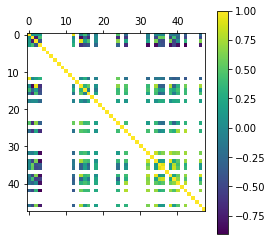

In [289]:
plt.matshow(corr_matrix)
plt.colorbar()

In [290]:
indexes = np.where(corr_matrix)

In [291]:
indexes_row = indexes[0]
indexes_col = indexes[1]

In [293]:
high_corr_row = [columns_correlation[i] for i in indexes_row]
high_corr_col = [columns_correlation[i] for i in indexes_col]
correlations = [corr_matrix[i,j] for i,j in zip(indexes_row, indexes_col)]

In [294]:
import pandas as pd

In [295]:
correlation_df = pd.DataFrame({
    'metric1' : high_corr_row,
    'metric2' : high_corr_col,
    'correlation' : correlations}
)

In [296]:
# get rid of trivial correlation
correlation_df = correlation_df[ correlation_df['metric1']!=correlation_df['metric2']]

array([[<AxesSubplot:title={'center':'correlation'}>]], dtype=object)

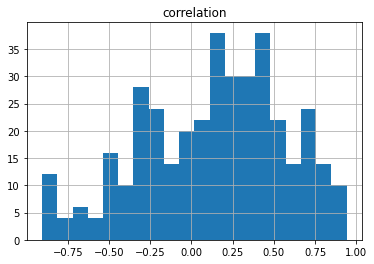

In [297]:
correlation_df.hist(bins=20)

In [298]:
threshold = 0.6

In [299]:
correlation_df = correlation_df[np.abs(correlation_df['correlation']) > threshold]

In [305]:
correlation_df = correlation_df[correlation_df['metric1'].str.startswith('a') & correlation_df['metric2'].str.startswith('S')]

In [309]:
correlation_df.sort_values(by=['correlation'], ascending=False)

,metric1,metric2,correlation
2042,anom_S169_SW-106,S178_SW-106,0.780659
1838,anom_S118_SW-106,S10_SW-106,0.776555
1646,anom_S117_SW-106,S10_SW-106,0.747542
2222,anom_S170_SW-106,S10_SW-106,0.743876
1946,anom_S169_SW-065,S178_SW-106,0.742311
1826,anom_S118_SW-106,S39_SW-106,0.635759
2210,anom_S170_SW-106,S39_SW-106,0.629445
1634,anom_S117_SW-106,S39_SW-106,0.606114
2211,anom_S170_SW-106,S39_SW-115,-0.773157
1923,anom_S169_SW-065,S39_SW-115,-0.833527


# Exercise 2: Anomaly Detection <a class="anchor" id="anomaly2"></a>

As before, the devices in the dataset have 4 different engines which have to compress a
gas to chill or heat the environment. The percentage of working/loading of those units
is extremely important due to it could indicate problems related to under-dimensioned
or over-dimensioned devices, deterioration of some mechanical parts, or not suitable
external environment conditions. For this point, the task is:

• Identify some possible correlations between the percentage of device loading and
the external temperature
The metrics/variables that contain the information about the loading percentage of the
devices are:

• S125 (ergated capacity by circuit 1)

• S1181 (ergated capacity by circuit 2)

A device can have one or both variables.


In [20]:
perc_metric = ['S125', 'S181']
temp_metric = ['S41']

metrics = ['S125', 'S181', 'S41']
hwids_list = ['SW-065', 'SW-088', 'SW-106', 'SW-115']

timestep = 120 #sec

In [25]:
ref_timegrid = get_reference_timegrid(df=df_limited, ref_metrics=metrics, timestep=timestep)

In [26]:
df_ex2 = normalize_frequencies_by_hwid(df_limited, metrics_list=metrics, hwids_list=hwids_list, ref_timegrid=ref_timegrid, timestep=timestep)

In [27]:
df_ex2.printSchema()

root
 |-- index: integer (nullable = false)
 |-- S125_SW-065: double (nullable = true)
 |-- S125_SW-088: double (nullable = true)
 |-- S125_SW-106: double (nullable = true)
 |-- S125_SW-115: double (nullable = true)
 |-- S181_SW-065: double (nullable = true)
 |-- S181_SW-088: double (nullable = true)
 |-- S181_SW-106: double (nullable = true)
 |-- S181_SW-115: double (nullable = true)
 |-- S41_SW-065: double (nullable = true)
 |-- S41_SW-088: double (nullable = true)
 |-- S41_SW-106: double (nullable = true)
 |-- S41_SW-115: double (nullable = true)



In [28]:
df_ex2.cache().count()

22/07/08 11:05:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 11:05:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 11:05:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 11:05:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 11:05:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 11:05:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

28

In [29]:
df_ex2.toPandas().to_csv('df_ex2.csv')

In [30]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [31]:
df_ex2_to_correlate = df_ex2.drop('index')

In [32]:
dim_corr_matrix = len(df_ex2_to_correlate.columns)

In [33]:
columns_correlation = df_ex2_to_correlate.columns

# [Correlation with a threshold on anomaly]

In [34]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_ex2_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_ex2_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)


22/07/08 11:07:07 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.
/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [35]:
corr_matrix = matrix.collect()[0]["pearson({})".format(vector_col)].values

In [36]:
corr_matrix = corr_matrix.reshape(dim_corr_matrix,dim_corr_matrix)

In [37]:
import matplotlib.pyplot as plt

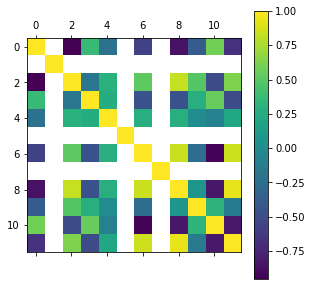

In [38]:
plt.matshow(corr_matrix)
plt.colorbar()

In [39]:
indexes = np.where(corr_matrix)

In [40]:
indexes_row = indexes[0]
indexes_col = indexes[1]

In [41]:
high_corr_row = [columns_correlation[i] for i in indexes_row]
high_corr_col = [columns_correlation[i] for i in indexes_col]
correlations = [corr_matrix[i,j] for i,j in zip(indexes_row, indexes_col)]

In [42]:
import pandas as pd

In [57]:
correlation_df = pd.DataFrame({
    'metric1' : high_corr_row,
    'metric2' : high_corr_col,
    'correlation' : correlations}
)

In [58]:
# get rid of trivial correlation
correlation_df = correlation_df[ correlation_df['metric1']!=correlation_df['metric2']]

array([[<AxesSubplot:title={'center':'correlation'}>]], dtype=object)

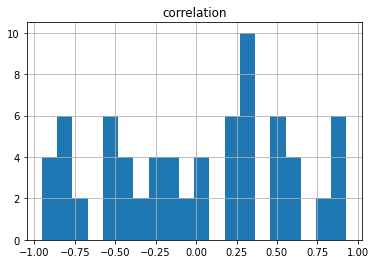

In [59]:
correlation_df.hist(bins=20)

In [60]:
threshold = 0.1

In [61]:
correlation_df = correlation_df[np.abs(correlation_df['correlation']) > threshold]

In [64]:
correlation_df = correlation_df[correlation_df['metric1'].str.startswith('S41') & ~(correlation_df['metric2'].str.startswith('S41'))]

In [65]:
correlation_df.sort_values(by=['correlation'], ascending=False)

,metric1,metric2,correlation
138,S41_SW-115,S181_SW-106,0.852397
102,S41_SW-065,S181_SW-106,0.844367
98,S41_SW-065,S125_SW-106,0.830761
134,S41_SW-115,S125_SW-106,0.619549
120,S41_SW-106,S125_SW-065,0.583433
123,S41_SW-106,S125_SW-115,0.549257
110,S41_SW-088,S125_SW-106,0.483499
100,S41_SW-065,S181_SW-065,0.278270
111,S41_SW-088,S125_SW-115,0.268056
136,S41_SW-115,S181_SW-065,0.221771


# Assignment 3: Predictive Maintenace <a class="anchor" id="predmain"></a>

As written in the previous section, variables A5 and A9 contain alarms about the devices.
More specifically, if one (or all) of the bit in positions 6, 7, and 8, of one/both the alarm/s,
are equal to 1 this means that there is/are one/some faulty/ies. In fact, if at least one of
the cited bits is at 1, it means the engines are overheating.
For this point the task is:

• Convert the alarms from their integer encoding to their bit string and then identify correctly the required alarms

• Once the alarms have been identified find some possible correlation between the variables and those alarms.

• With the figured out correlations, try to predict an alarm in the future. E.g: given
a set of correlated features (variable) at time T i−1 try to predict if at time T i there
will a fault or not.
The metrics/variables that contain the information about the alarms are:

• A5
• A9


In [19]:
alarm_metric = ['A5', 'A9']
# choosing among metrics related to temperatures
other_metrics = ['S40', 'S39', 'S41', 'S3', 'S109', 'S107']

hwids_list = ['SW-065', 'SW-088', 'SW-106', 'SW-115']

metrics = ['A5', 'A9', 'S40', 'S39', 'S41', 'S3', 'S109', 'S107']

timestep = 30 #sec

In [20]:
ref_timegrid = get_reference_timegrid(df=df_limited, ref_metrics=alarm_metric, timestep=timestep)

In [21]:
df_ex3 = normalize_frequencies_by_hwid(df_limited, metrics_list=metrics, hwids_list=hwids_list, ref_timegrid=ref_timegrid, timestep=timestep)


In [22]:
# # putting 0 to null values
# df_ex3 = df_ex3.na.fill(value=0)

In [23]:
# with the limited dataset it is normal to have null values
df_ex3.show()

22/07/08 15:28:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/07/08 15:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradat

22/07/08 15:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:28:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:29:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:29:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:29:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:29:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:29:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:29:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:29:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:30:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|index|A5_SW-065|A5_SW-088|A5_SW-106|A5_SW-115|A9_SW-065|A9_SW-088|A9_SW-106|A9_SW-115|S40_SW-065|S40_SW-088|S40_SW-106|S40_SW-115|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|S41_SW-065|S41_SW-088|S41_SW-106|S41_SW-115|S3_SW-065|S3_SW-088|S3_SW-106|S3_SW-115|S109_SW-065|S109_SW-088|S109_SW-106|S109_SW-115|S107_SW-065|S107_SW-088|S107_SW-106|S107_SW-115|
+-----+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----

## Mapping A5 and A9 metrics to string of 16 bit

In [15]:
from pyspark.sql.types import StringType

In [16]:
map_to_16bit = udf(lambda x: '{0:016b}'.format(int(x)), StringType())

In [26]:
columns_3 = df_ex3.columns
anomaly_col = columns_3[:9]
anomaly_col.remove('index')

In [27]:
anomaly_col

['A5_SW-065',
 'A5_SW-088',
 'A5_SW-106',
 'A5_SW-115',
 'A9_SW-065',
 'A9_SW-088',
 'A9_SW-106',
 'A9_SW-115']

In [28]:
for col_name in anomaly_col:
    df_ex3 = df_ex3.withColumn(col_name+"_16bit",map_to_16bit(col(col_name))).drop(col_name)


In [29]:
df_ex3.cache().show()

22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:30:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 1

+-----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
|index|S40_SW-065|S40_SW-088|S40_SW-106|S40_SW-115|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|S41_SW-065|S41_SW-088|S41_SW-106|S41_SW-115|S3_SW-065|S3_SW-088|S3_SW-106|S3_SW-115|S109_SW-065|S109_SW-088|S109_SW-106|S109_SW-115|S107_SW-065|S107_SW-088|S107_SW-106|S107_SW-115| A5_SW-065_16bit| A5_SW-088_16bit| A5_SW-106_16bit| A5_SW-115_16bit| A9_SW-065_16bit| A9_SW-088_16bit| A9_SW-106_16bit| A9_SW-115_16bit|
+-----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+-------



## Cut string of 16bit in meaningfull places, i.e. bits 6 , 7 and 8. map directly to label 1 if either one of the 3 is 1. to label 0 otherwise.

In [17]:
from pyspark.sql.types import IntegerType # int(x[5]) + int(x[6])+ int(x[7])

In [18]:
cut_b = udf(lambda x:  int(x[5] or x[6] or x[7]), IntegerType())

In [64]:
columns_3 = df_ex3.columns
anomaly_col = columns_3[len(columns_3)-8:len(columns_3)]
anomaly_col

['A5_SW-065_16bit',
 'A5_SW-088_16bit',
 'A5_SW-106_16bit',
 'A5_SW-115_16bit',
 'A9_SW-065_16bit',
 'A9_SW-088_16bit',
 'A9_SW-106_16bit',
 'A9_SW-115_16bit']

In [65]:
df_ex3_anomaly = df_ex3 

In [66]:
for col_name in anomaly_col:
    df_ex3_anomaly = df_ex3_anomaly.withColumn(col_name+"_anomaly",cut_b(col(col_name))).drop(col_name)


In [67]:
df_ex3_anomaly.show()

22/07/08 15:48:19 WARN DAGScheduler: Broadcasting large task binary with size 1215.8 KiB


+-----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|index|S40_SW-065|S40_SW-088|S40_SW-106|S40_SW-115|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|S41_SW-065|S41_SW-088|S41_SW-106|S41_SW-115|S3_SW-065|S3_SW-088|S3_SW-106|S3_SW-115|S109_SW-065|S109_SW-088|S109_SW-106|S109_SW-115|S107_SW-065|S107_SW-088|S107_SW-106|S107_SW-115|A5_SW-065_16bit_anomaly|A5_SW-088_16bit_anomaly|A5_SW-106_16bit_anomaly|A5_SW-115_16bit_anomaly|A9_SW-065_16bit_anomaly|A9_SW-088_16bit_anomaly|A9_SW-106_16bit_anomaly|A9_SW-115_16bit_anomaly|
+-----+----------+----------+----------+----------+----------+--

In [68]:
columns_3 = df_ex3_anomaly.columns
anomaly_col = columns_3[len(columns_3)-8:len(columns_3)]
anomaly_col

['A5_SW-065_16bit_anomaly',
 'A5_SW-088_16bit_anomaly',
 'A5_SW-106_16bit_anomaly',
 'A5_SW-115_16bit_anomaly',
 'A9_SW-065_16bit_anomaly',
 'A9_SW-088_16bit_anomaly',
 'A9_SW-106_16bit_anomaly',
 'A9_SW-115_16bit_anomaly']

In [69]:
col_A5 = anomaly_col[:4]
col_A5

['A5_SW-065_16bit_anomaly',
 'A5_SW-088_16bit_anomaly',
 'A5_SW-106_16bit_anomaly',
 'A5_SW-115_16bit_anomaly']

In [70]:
col_A9 = anomaly_col[4:]
col_A9

['A9_SW-065_16bit_anomaly',
 'A9_SW-088_16bit_anomaly',
 'A9_SW-106_16bit_anomaly',
 'A9_SW-115_16bit_anomaly']

In [71]:
# # join A5 column to have just one label

# df_ex3_anomaly = df_ex3_anomaly.withColumn('A5_tot', col(col_A5[0]).cast('boolean') | col(col_A5[1])\
#                           .cast('boolean') | col(col_A5[2]).cast('boolean') | col(col_A5[3]).cast('boolean'))\
#                             .drop(col_A5[0],col_A5[1],col_A5[2],col_A5[3])

# df_ex3_anomaly = df_ex3_anomaly.withColumn('A9_tot', col(col_A9[0]).cast('boolean') | col(col_A9[1])\
#                           .cast('boolean') | col(col_A9[2]).cast('boolean') | col(col_A9[3]).cast('boolean'))\
#                             .drop(col_A9[0],col_A9[1],col_A9[2],col_A9[3])


In [72]:
# join A5 column to have just one label

df_ex3_anomaly = df_ex3_anomaly.withColumn('A5_tot', col(col_A5[0])+col(col_A5[1])+col(col_A5[2])+col(col_A5[3]))\
                            .drop(col_A5[0],col_A5[1],col_A5[2],col_A5[3])

df_ex3_anomaly = df_ex3_anomaly.withColumn('A9_tot', col(col_A9[0])+col(col_A9[1])+col(col_A9[2])+col(col_A9[3]))\
                            .drop(col_A9[0],col_A9[1],col_A9[2],col_A9[3])

In [44]:
# df_ex3_anomaly = df_ex3_anomaly.withColumn('A5_tot', col('A5_tot').cast('int'))
# df_ex3_anomaly = df_ex3_anomaly.withColumn('A9_tot', col('A9_tot').cast('int'))

In [73]:
df_ex3_anomaly.show()

22/07/08 15:48:40 WARN DAGScheduler: Broadcasting large task binary with size 1215.3 KiB


+-----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------+------+
|index|S40_SW-065|S40_SW-088|S40_SW-106|S40_SW-115|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|S41_SW-065|S41_SW-088|S41_SW-106|S41_SW-115|S3_SW-065|S3_SW-088|S3_SW-106|S3_SW-115|S109_SW-065|S109_SW-088|S109_SW-106|S109_SW-115|S107_SW-065|S107_SW-088|S107_SW-106|S107_SW-115|A5_tot|A9_tot|
+-----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------+------+
|    1|     136.0|     103.0|      71.0|     150.0|     151.0|     103.0|     100.0|     148.0|     182.0|     178.0|     232.0|  

In [74]:
w = Window().partitionBy().orderBy(col("index"))
df_ex3_shift = df_ex3_anomaly.select("*", lag("A5_tot").over(w).alias("A5_shift")).na.drop()
df_ex3_shift = df_ex3_shift.select("*", lag("A9_tot").over(w).alias("A9_shift")).na.drop()

In [75]:
df_ex3_shift.show()

22/07/08 15:48:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:48:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:48:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:48:58 WARN DAGScheduler: Broadcasting large task binary with size 1210.8 KiB
22/07/08 15:48:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:48:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1244.5 K

+-----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------+------+--------+--------+
|index|S40_SW-065|S40_SW-088|S40_SW-106|S40_SW-115|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|S41_SW-065|S41_SW-088|S41_SW-106|S41_SW-115|S3_SW-065|S3_SW-088|S3_SW-106|S3_SW-115|S109_SW-065|S109_SW-088|S109_SW-106|S109_SW-115|S107_SW-065|S107_SW-088|S107_SW-106|S107_SW-115|A5_tot|A9_tot|A5_shift|A9_shift|
+-----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------+------+--------+--------+
|    3|     137.0|     103.0|      75.0|     151.0|     152.0|     103.0|   

In [48]:
df_ex3_shift.count()

22/07/08 15:43:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:43:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:43:47 WARN DAGScheduler: Broadcasting large task binary with size 1212.5 KiB
22/07/08 15:43:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:43:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:43:47 WARN DAGScheduler: Broadcasting large task binary with size 1238.1 KiB


28851

# Correlation with rolling sum over alarms A5 and A9

In [111]:
w_sum = (Window.orderBy(col("index")).rangeBetween(0, 10))

df_ex3_shift = df_ex3_shift.withColumn('A5_sum', func.sum(col('A5_tot')).over(w_sum))
df_ex3_shift = df_ex3_shift.withColumn('A9_sum', func.sum(col('A9_tot')).over(w_sum))


In [112]:
df_to_correlate = df_ex3_shift.drop('A5_tot','A9_tot','A5_shift','A9_shift', 'index')

In [100]:
dim_corr_matrix = len(df_to_correlate.columns)
columns_correlation = df_to_correlate.columns

In [91]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_to_correlate.columns, outputCol=vector_col)
df_vector = assembler.transform(df_to_correlate).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)


22/07/08 15:55:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:55:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:55:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:55:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:55:49 WARN DAGScheduler: Broadcasting large task binary with size 1210.8 KiB
22/07/08 15:55:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:55:50 WARN WindowExec: No Partition Defined for Window operation! Moving a

In [92]:
corr_matrix = matrix.collect()[0]["pearson({})".format(vector_col)].values

In [94]:
corr_matrix = corr_matrix.reshape(dim_corr_matrix,dim_corr_matrix)

In [95]:
import matplotlib.pyplot as plt

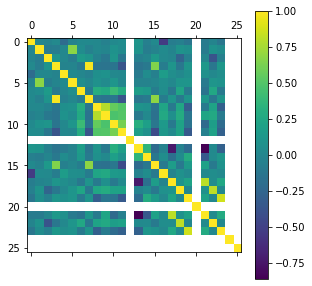

In [96]:
plt.matshow(corr_matrix)
plt.colorbar()

In [116]:
indexes = np.where(corr_matrix)

In [117]:
indexes_row = indexes[0]
indexes_col = indexes[1]

In [118]:
high_corr_row = [columns_correlation[i] for i in indexes_row]
high_corr_col = [columns_correlation[i] for i in indexes_col]
correlations = [corr_matrix[i,j] for i,j in zip(indexes_row, indexes_col)]

In [119]:
import pandas as pd

In [120]:
correlation_df = pd.DataFrame({
    'metric1' : high_corr_row,
    'metric2' : high_corr_col,
    'correlation' : correlations}
)

In [121]:
# get rid of trivial correlation
correlation_df = correlation_df[ correlation_df['metric1']!=correlation_df['metric2']]

array([[<AxesSubplot:title={'center':'correlation'}>]], dtype=object)

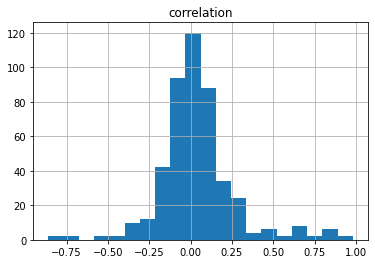

In [122]:
correlation_df.hist(bins=20)

In [123]:
threshold = 0.1

In [124]:
correlation_df = correlation_df[np.abs(correlation_df['correlation']) > threshold]

In [125]:
correlation_df = correlation_df[correlation_df['metric1'].str.startswith('A') & ~(correlation_df['metric2'].str.startswith('A'))]

In [126]:
correlation_df.sort_values(by=['correlation'], ascending=False)

,metric1,metric2,correlation


# Correlation with Random Forest feature importances

## Random Forest <a class="anchor" id="forest"></a>

<p align="left">
<img src="figures/forest.png"  width="600"/> </p>
<p align="left">

In [76]:
import numpy
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

In [77]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [78]:
# data = df_ex3_shift.drop('A9_tot','A5_tot', 'A9_shift', 'index')
data = df_ex3_shift.drop('A9_tot','A5_tot', 'A9_shift', 'index')

In [79]:
data.cache().show()

22/07/08 15:49:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:49:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/07/08 15:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1210.8 KiB
22/07/08 15:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1258.3 KiB


+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+
|S40_SW-065|S40_SW-088|S40_SW-106|S40_SW-115|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|S41_SW-065|S41_SW-088|S41_SW-106|S41_SW-115|S3_SW-065|S3_SW-088|S3_SW-106|S3_SW-115|S109_SW-065|S109_SW-088|S109_SW-106|S109_SW-115|S107_SW-065|S107_SW-088|S107_SW-106|S107_SW-115|A5_shift|
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+
|     137.0|     103.0|      75.0|     151.0|     152.0|     103.0|     100.0|     150.0|     183.0|     177.0|     232.0|     152.0|    145.0|    125.0|     91.0|

In [80]:
from pyspark.ml.feature import VectorAssembler

numericCols = data.columns[:-1]
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
data = assembler.transform(data)
data.show()

+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+--------------------+
|S40_SW-065|S40_SW-088|S40_SW-106|S40_SW-115|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|S41_SW-065|S41_SW-088|S41_SW-106|S41_SW-115|S3_SW-065|S3_SW-088|S3_SW-106|S3_SW-115|S109_SW-065|S109_SW-088|S109_SW-106|S109_SW-115|S107_SW-065|S107_SW-088|S107_SW-106|S107_SW-115|A5_shift|            features|
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+--------------------+
|     137.0|     103.0|      75.0|     151.0|     152.0|     103.0|     100.0|     150.0|     183.0|

22/07/08 15:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1276.5 KiB


In [81]:
from pyspark.ml.feature import StringIndexer

label_stringIdx = StringIndexer(inputCol = 'A5_shift', outputCol = 'labelIndex')
data = label_stringIdx.fit(data).transform(data)
data.show()

22/07/08 15:49:18 WARN DAGScheduler: Broadcasting large task binary with size 1247.0 KiB


+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+--------------------+----------+
|S40_SW-065|S40_SW-088|S40_SW-106|S40_SW-115|S39_SW-065|S39_SW-088|S39_SW-106|S39_SW-115|S41_SW-065|S41_SW-088|S41_SW-106|S41_SW-115|S3_SW-065|S3_SW-088|S3_SW-106|S3_SW-115|S109_SW-065|S109_SW-088|S109_SW-106|S109_SW-115|S107_SW-065|S107_SW-088|S107_SW-106|S107_SW-115|A5_shift|            features|labelIndex|
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+---------+---------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+--------------------+----------+
|     137.0|     103.0|      75.0|     151.0|     152.0|     103.0|

22/07/08 15:49:19 WARN DAGScheduler: Broadcasting large task binary with size 1285.8 KiB


In [82]:
train, test = data.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

22/07/08 15:49:21 WARN DAGScheduler: Broadcasting large task binary with size 1294.4 KiB


Training Dataset Count: 20222


22/07/08 15:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1294.4 KiB


Test Dataset Count: 8629


In [83]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'labelIndex')
rfModel = rf.fit(train)

22/07/08 15:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1303.0 KiB
22/07/08 15:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1303.1 KiB
22/07/08 15:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1308.1 KiB
22/07/08 15:49:25 WARN DAGScheduler: Broadcasting large task binary with size 1313.2 KiB


In [84]:
predictions = rfModel.transform(test)
# predictions.select('sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'labelIndex', 'rawPrediction', 'prediction', 'probability').show(25)

In [85]:
predictions.select('rawPrediction', 'probability', 'prediction','A5_shift').show()

22/07/08 15:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1361.3 KiB


+-------------+-----------+----------+--------+
|rawPrediction|probability|prediction|A5_shift|
+-------------+-----------+----------+--------+
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|       0|
|       [20.0]|      [1.0]|       0.0|  

In [86]:
predictions.groupBy('A5_shift').count().show()

22/07/08 15:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1305.3 KiB


+--------+-----+
|A5_shift|count|
+--------+-----+
|       0| 8629|
+--------+-----+



In [58]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

22/07/08 14:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1390.1 KiB


Accuracy = 1.0
Test Error = 0.0


In [59]:
feature_imp = rfModel.featureImportances.toArray().tolist()
feature_imp

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

# [CHECK FOR A9 and A5 ALARMS]

In [12]:
df_A5_A9 = df.filter((df.metric=='A5') | (df.metric=='A9'))

In [13]:
df_A5_A9.show()

+----------+------+------+-----+
|      when|  hwid|metric|value|
+----------+------+------+-----+
|1601511411|SW-065|    A5|    0|
|1601511411|SW-065|    A9|    0|
|1601539597|SW-065|    A9|    0|
|1601539597|SW-065|    A5|    0|
|1601597328|SW-065|    A5|    0|
|1601597328|SW-065|    A9|    0|
|1601632934|SW-065|    A5|    0|
|1601632934|SW-065|    A9|    0|
|1601671003|SW-065|    A5|    0|
|1601671003|SW-065|    A9|    0|
|1601674488|SW-065|    A9|    0|
|1601674488|SW-065|    A5|    0|
|1601676687|SW-065|    A5|    0|
|1601676687|SW-065|    A9|    0|
|1601679623|SW-065|    A5|    0|
|1601679623|SW-065|    A9|    0|
|1601683605|SW-065|    A5|    0|
|1601683605|SW-065|    A9|    0|
|1601685256|SW-065|    A5|    0|
|1601685256|SW-065|    A9|    0|
+----------+------+------+-----+
only showing top 20 rows



In [21]:
df_A5_A9.count()

1332

In [19]:
df_A5_A9 = df_A5_A9.withColumn('16bit',map_to_16bit(col('value')))
df_A5_A9 = df_A5_A9.withColumn("anomaly",cut_b(col('16bit')))

In [20]:
df_A5_A9.groupBy('anomaly').count().show()

+-------+-----+
|anomaly|count|
+-------+-----+
|      0| 1325|
|      1|    7|
+-------+-----+



In [27]:
when_A5 = df_A5_A9.select('when').where(col('anomaly')==1).where(col('metric')=='A5').collect()
when_A9 = df_A5_A9.select('when').where(col('anomaly')==1).where(col('metric')=='A9').collect()

In [32]:
when_A5 = np.array([el[0] for el in when_A5])
when_A9 = np.array([el[0] for el in when_A9])

In [38]:
np.diff(np.sort(when_A5))/3600

array([1478.31527778,    3.45527778,    4.69694444,    2.39361111])

In [39]:
np.diff(np.sort(when_A9))/3600

array([3.04305556])

In [ ]:
# si_model = stringIndexer.fit(df)
# td = si_model.transform(df)
# rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="indexed", seed=42,
#     leafCol="leafId")
# rf.getMinWeightFractionPerNode()

# model = rf.fit(td)
# model.getLabelCol()

# model.setFeaturesCol("features")

# model.setRawPredictionCol("newRawPrediction")

# model.getBootstrap()

# model.getRawPredictionCol()

# model.featureImportances

# allclose(model.treeWeights, [1.0, 1.0, 1.0])

# test0 = spark.createDataFrame([(Vectors.dense(-1.0),)], ["features"])
# model.predict(test0.head().features)

# model.predictRaw(test0.head().features)

# model.predictProbability(test0.head().features)

# result = model.transform(test0).head()
# result.prediction

# numpy.argmax(result.probability)

# numpy.argmax(result.newRawPrediction)

# result.leafId

# test1 = spark.createDataFrame([(Vectors.sparse(1, [0], [1.0]),)], ["features"])
# model.transform(test1).head().prediction

# model.trees

# rfc_path = temp_path + "/rfc"
# rf.save(rfc_path)
# rf2 = RandomForestClassifier.load(rfc_path)
# rf2.getNumTrees()

# model_path = temp_path + "/rfc_model"
# model.save(model_path)
# model2 = RandomForestClassificationModel.load(model_path)
# model.featureImportances == model2.featureImportances

# model.transform(test0).take(1) == model2.transform(test0).take(1)

# Support Vector Machine (SVM)

In [44]:
from pyspark.ml.classification import LinearSVC

In [45]:
from pyspark.sql import Row

from pyspark.ml.linalg import Vectors

In [46]:
df = sc.parallelize([
    Row(label=1.0, features=Vectors.dense(1.0, 1.0, 1.0)),
    Row(label=0.0, features=Vectors.dense(1.0, 2.0, 3.0))]).toDF()

svm = LinearSVC()

svm.getMaxIter()

svm.setMaxIter(5)

svm.getMaxIter()

svm.getRegParam()

svm.setRegParam(0.01)

svm.getRegParam()

model = svm.fit(df)
model.setPredictionCol("newPrediction")

model.getPredictionCol()

model.setThreshold(0.5)

model.getThreshold()

model.getMaxBlockSizeInMB()

model.coefficients

model.intercept

model.numClasses

model.numFeatures

test0 = sc.parallelize([Row(features=Vectors.dense(-1.0, -1.0, -1.0))]).toDF()
model.predict(test0.head().features)

model.predictRaw(test0.head().features)

result = model.transform(test0).head()
result.newPrediction

result.rawPrediction

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 